In [1]:
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import yaml
from plot_ellipticity import (
    create_folium_map,
    get_boundary_centroid,
    plot_histogram,
    plot_stops,
)
from shapely import Point
from sklearn.preprocessing import minmax_scale

with open("../data/crs.yaml", "r") as fp:
    crs = yaml.safe_load(fp)
with open("../plotting_config.yaml", "r") as fp:
    config = yaml.safe_load(fp)

In [2]:
CITY = "helsinki"
VERSION = "20250411"

In [3]:
data = pd.read_csv(f"../output/{CITY}/{VERSION}/merged.csv")
data["geometry"] = data.apply(lambda x: Point(x["stop_lon"], x["stop_lat"]), axis=1)
data = gpd.GeoDataFrame(data, geometry="geometry", crs=4326)

boundary = gpd.read_file(f"../data/osm/{CITY}/boundary.geojson").to_crs(crs[CITY])
boundary_polygon = boundary.geometry[0]
lon, lat = get_boundary_centroid(boundary)

In [4]:
to_plot_el = data.sort_values("ellipticity", ascending=True).to_crs(crs[CITY])

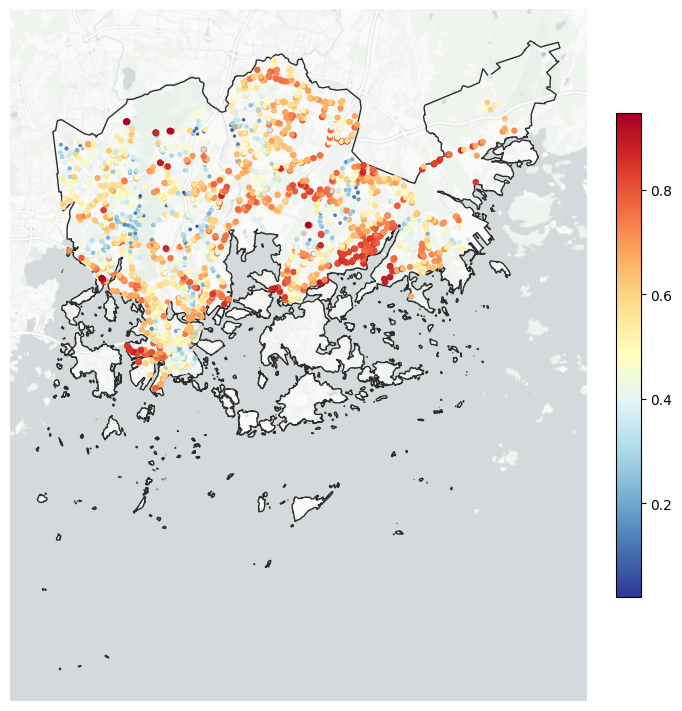

In [5]:
fig, ax = plt.subplots(figsize=(7, 7), layout="constrained")
boundary.plot(ax=ax, fc="none", ec="#2d2d2d")
gpd.clip(to_plot_el, boundary_polygon).plot(
    column="ellipticity",
    legend=True,
    legend_kwds={"shrink": 0.7},
    markersize=minmax_scale(
        gpd.clip(to_plot_el, boundary_polygon)["ellipticity"], feature_range=(1, 16)
    ),
    cmap="RdYlBu_r",
    ax=ax,
)
cx.add_basemap(
    ax,
    crs=crs[CITY],
    source=cx.providers.CartoDB.PositronNoLabels,
    alpha=1,
    attribution=False,
)
ax.axis("off")
ax.margins(0)
# for i in ["png"]:
#     fig.savefig(
#         f"../output/{CITY}/{VERSION}/ellipticity.{i}",
#         dpi=300,
#         facecolor="white",
#         bbox_inches="tight",
#         # pad_inches=0.1,
#         metadata=config["metadata"][i],
#     )

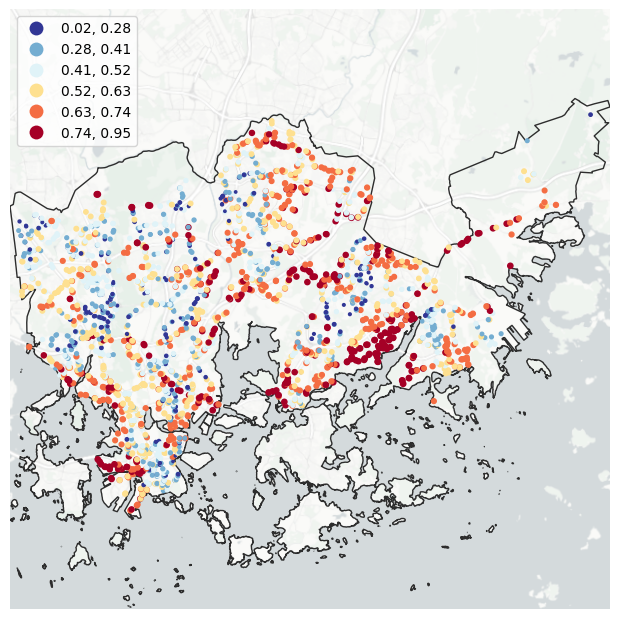

In [6]:
fig, ax = plot_stops(
    gpd.clip(to_plot_el, boundary_polygon).query("ellipticity.notna()"),
    boundary,
    "ellipticity",
    crs=crs[CITY],
)
for i in ["png"]:
    fig.savefig(
        f"../output/{CITY}/{VERSION}/ellipticity_jenks.{i}",
        dpi=300,
        facecolor="white",
        pad_inches=0,
        metadata=config["metadata"][i],
    )

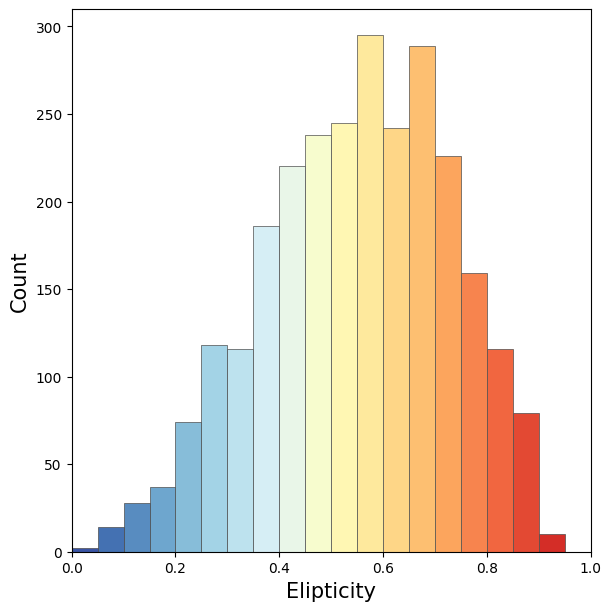

In [7]:
fig, ax = plot_histogram(to_plot_el)
for i in ["png"]:
    fig.savefig(
        f"../output/{CITY}/{VERSION}/ellipticity_histogram.{i}",
        dpi=300,
        facecolor="white",
        pad_inches=0,
        metadata=config["metadata"][i],
    )

In [8]:
m = create_folium_map(data, boundary, lon, lat)

In [9]:
m.save(f"../output/{CITY}/{VERSION}/folium.html")